In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from math import sqrt
import matplotlib.pyplot as plt
import gc

In [2]:
pickle_file = 'galaxies.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = (save['train_dataset'])
  train_labels = save['train_labels']
  valid_dataset = (save['valid_dataset'])[0:1000]
  valid_labels = (save['valid_labels'])[0:1000]
  test_dataset = (save['test_dataset'])[0:1000]
  test_labels = (save['test_labels'])[0:1000]
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 80, 80) (200000, 37)
Validation set (1000, 80, 80) (1000, 37)
Test set (1000, 80, 80) (1000, 37)


In [3]:
print(train_dataset[5])

[[-0.46470588 -0.47254902 -0.48823529 ..., -0.49215686 -0.49215686
  -0.49215686]
 [-0.46470588 -0.47254902 -0.48431373 ..., -0.48431373 -0.48823529
  -0.48823529]
 [-0.46862745 -0.47647059 -0.48431373 ..., -0.47647059 -0.48039216
  -0.48039216]
 ..., 
 [-0.48431373 -0.49215686 -0.5        ..., -0.46470588 -0.42941177
  -0.39803922]
 [-0.48431373 -0.49215686 -0.49215686 ..., -0.45686275 -0.41764706
  -0.39019608]
 [-0.48823529 -0.48823529 -0.48039216 ..., -0.45686275 -0.4254902
  -0.39803922]]


In [4]:
image_size = 80
num_labels = 37
num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  return dataset

def accuracy(predictions, labels):
    return np.sqrt(((predictions - labels) ** 2).mean())
    

In [5]:

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 80, 80, 1) (200000, 37)
Validation set (1000, 80, 80, 1) (1000, 37)
Test set (1000, 80, 80, 1) (1000, 37)


In [6]:
gc.collect()

187

In [7]:
batch_size = 128
patch_size = 5
depth = 32 #32, 16
num_hidden = 48 #50#100
num_hidden2 = 48 #50#37
beta = 0.0002 
graph = tf.Graph()

with graph.as_default():

  # Input data
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  learning_rate = tf.Variable(0.3)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    pred1 = tf.nn.softmax(logits[:,0:3])
    pred2 = tf.nn.relu(logits[:,3:num_labels])
    pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
    
  #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  
  valid_prediction =prediction(model(valid_dataset))
  test_prediction = prediction(model(test_dataset))

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

48
48


In [8]:
num_steps = 15000
t=0
i = []
trainloss = []
validloss = []
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      i.append(step)
      gc.collect()
      print('Minibatch loss at step %d: %f' % (step, l))
      trainloss.append(l)
      print('Minibatch accuracy: %f' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %f' % accuracy(
        valid_prediction.eval(), valid_labels))
      validloss.append(accuracy(valid_prediction.eval(), valid_labels))
      saver.save(session, './my-model11.ckpt')
        

  print('Test accuracy: %f' % accuracy(test_prediction.eval(), test_labels))
  plt.plot(15000, accuracy(test_prediction.eval(), test_labels), 'go')
    
  plt.plot(i, trainloss, 'r')
  plt.plot(i, validloss, 'b')
  plt.axis([0, 15000, 0, 0.5])
  t = accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0: 0.934167
Minibatch accuracy: 1.312427
Validation accuracy: 0.220783
Minibatch loss at step 500: 0.198056
Minibatch accuracy: 0.258812
Validation accuracy: 0.189577
Minibatch loss at step 1000: 0.174055
Minibatch accuracy: 0.265365
Validation accuracy: 0.165184
Minibatch loss at step 1500: 0.185106
Minibatch accuracy: 0.283319
Validation accuracy: 0.171767
Minibatch loss at step 2000: 0.169156
Minibatch accuracy: 0.256111
Validation accuracy: 0.158719
Minibatch loss at step 2500: 0.155521
Minibatch accuracy: 0.262591
Validation accuracy: 0.159571
Minibatch loss at step 3000: 0.155953
Minibatch accuracy: 0.274575
Validation accuracy: 0.144571
Minibatch loss at step 3500: 0.144823
Minibatch accuracy: 0.272510
Validation accuracy: 0.142794
Minibatch loss at step 4000: 0.132383
Minibatch accuracy: 0.265135
Validation accuracy: 0.141404
Minibatch loss at step 4500: 0.128904
Minibatch accuracy: 0.264093
Validation accuracy: 0.138322
Minibatch loss at step

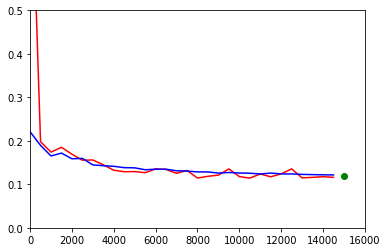

In [11]:
plt.plot(i, trainloss, 'r')
plt.plot(i, validloss, 'b')
plt.plot(15000, t, 'go')
plt.axis([0, 16000, 0, 0.5])
plt.show()

In [12]:
num_steps = 6000#60000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model8.ckpt')
    print("Model restored.") 
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          gc.collect()
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %f' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %f' % accuracy(
            valid_prediction.eval(), valid_labels))
          saver.save(session, './my-model11.ckpt')
    
    print('Test accuracy: %f' % accuracy(test_prediction.eval(), test_labels))
    
  

Model restored.
Initialized
Minibatch loss at step 0: 0.123043
Minibatch accuracy: 0.271451
Validation accuracy: 0.129672
Minibatch loss at step 500: 0.123144
Minibatch accuracy: 0.266289
Validation accuracy: 0.127699
Minibatch loss at step 1000: 0.129410
Minibatch accuracy: 0.262100
Validation accuracy: 0.130589
Minibatch loss at step 1500: 0.129361
Minibatch accuracy: 0.279013
Validation accuracy: 0.129719
Minibatch loss at step 2000: 0.126717
Minibatch accuracy: 0.259416
Validation accuracy: 0.127769
Minibatch loss at step 2500: 0.120453
Minibatch accuracy: 0.270692
Validation accuracy: 0.127024
Minibatch loss at step 3000: 0.127933
Minibatch accuracy: 0.273752
Validation accuracy: 0.126708
Minibatch loss at step 3500: 0.126988
Minibatch accuracy: 0.280714
Validation accuracy: 0.126501
Minibatch loss at step 4000: 0.111551
Minibatch accuracy: 0.257914
Validation accuracy: 0.125689
Minibatch loss at step 4500: 0.119802
Minibatch accuracy: 0.257974
Validation accuracy: 0.129427
Miniba